In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_dir = '/content/drive/MyDrive/colab/drowsiness_dataset/'
eye_training_set = '/content/drive/MyDrive/colab/drowsiness_dataset/train/eye_state_detection'
eye_testing_set = '/content/drive/MyDrive/colab/drowsiness_dataset/test/eye_state_detection'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMG_SIZE = (224,224)

# Create an ImageDataGenerator for training with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.0],
    validation_split=0.2  # 20% of training data for validation
)

# Create an ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test set

# Load and preprocess training data (80% for training)
train_data = train_datagen.flow_from_directory(
    eye_training_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    subset='training'  # Specify subset as training
)

# Load and preprocess validation data (20% for validation)
validation_data = train_datagen.flow_from_directory(
    eye_training_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary',
    subset='validation'  # Specify subset as validation
)

# Load and preprocess test data
test_data = test_datagen.flow_from_directory(
    eye_testing_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary'
)


Found 988 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [ ]:
# Print the number of images in each dataset
print(f"Number of images in training dataset: {train_data.samples}")
print(f"Number of images in validation dataset: {validation_data.samples}")
print(f"Number of images in test dataset: {test_data.samples}")


Number of images in training dataset: 988
Number of images in validation dataset: 246
Number of images in test dataset: 218


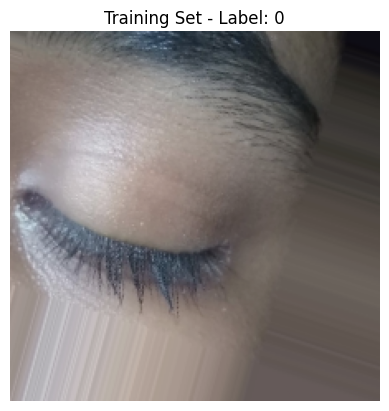

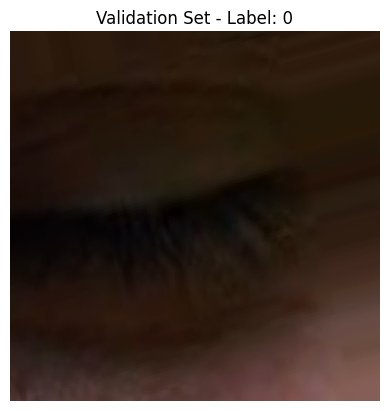

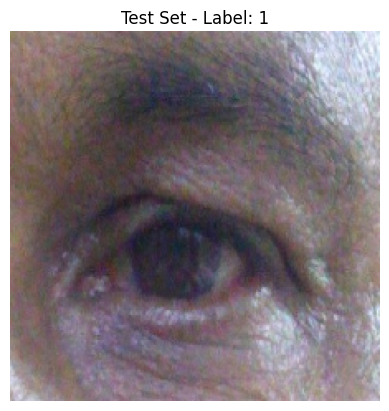

In [ ]:
# Function to display an image and its label
def show_image(data, title):
    # Get a batch of images and labels
    images, labels = next(data)

    # Convert from (batch_size, height, width, channels) to (height, width, channels)
    image = images[0]  # First image in the batch
    label = labels[0]  # First label in the batch

    # Display the image
    plt.imshow(image)
    plt.title(f"{title} - Label: {int(label)}")  # Display label (0 or 1 for binary classification)
    plt.axis('off')
    plt.show()

# Display one image from the training set
show_image(train_data, "Training Set")

# Display one image from the validation set
show_image(validation_data, "Validation Set")

# Display one image from the test set
show_image(test_data, "Test Set")


# CNN Model for 50 epochs


In [ ]:
model = Sequential([
    # First Conv block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Conv block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Conv block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

  # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully connected layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer (binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,449 (501.75 KB)

 Trainable params: 127,489 (498.00 KB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Define early stopping and model checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colab/cnn_eye_best_weights_only.weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True)  # Save only the weights during training

# Train the model, using the validation data instead of the test data for validation
history = model.fit(
    train_data,               # Training data
    epochs=50,                # Number of epochs
    validation_data=validation_data,  # Use validation set here
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 240s 9s/step - binary_accuracy: 0.5144 - loss: 0.9456 - val_binary_accuracy: 0.5041 - val_loss: 0.6934
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 934ms/step - binary_accuracy: 0.5247 - loss: 0.8546 - val_binary_accuracy: 0.5000 - val_loss: 0.6967
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 908ms/step - binary_accuracy: 0.5579 - loss: 0.8285 - val_binary_accuracy: 0.5000 - val_loss: 0.7023
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 927ms/step - binary_accuracy: 0.5680 - loss: 0.7991 - val_binary_accuracy: 0.5000 - val_loss: 0.6952
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 921ms/step - binary_accuracy: 0.5434 - loss: 0.8086 - val_binary_accuracy: 0.5000 - val_loss: 0.7028
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 951ms/step - binary_accuracy: 0.6334 - loss: 0.6997 - val_binary_accuracy: 0.5000 - val_loss: 0.7219
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 942ms/step - binary_accuracy: 0.5820 - loss: 0.7604 - val_binary_accuracy: 0.5000 - val_loss: 0.7535
Epoch 8/50
1

In [ ]:
# After training completes, load the best weights saved by the checkpoint
model.load_weights('/content/drive/MyDrive/colab/cnn_eye_best_weights_only.weights.h5')

# Now, save the entire model with the best weights and architecture
model.save('/content/drive/MyDrive/colab/cnn_eye_best_full_model.keras')

In [ ]:
# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print minimum validation loss
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# Test accuracy

In [4]:
eye_testing_set = '/content/drive/MyDrive/colab/drowsiness_dataset/test/eye_state_detection'
model = Sequential([
    # First Conv block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Conv block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Conv block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

  # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully connected layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer (binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Summary of the model
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,449 (501.75 KB)

 Trainable params: 127,489 (498.00 KB)

 Non-trainable params: 960 (3.75 KB)

In [5]:





# Define paths to your saved models
model_paths = [
    '/content/drive/MyDrive/colab/cnn_eye_best_weights_only.weights.h5',
]


# Image size to match the model input
IMG_SIZE = (224, 224)

# Create an ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess test data
test_data = test_datagen.flow_from_directory(
    eye_testing_set,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='binary'
)

# Function to evaluate a model on test data and print accuracy
def evaluate_model(model_path, test_data):
    # Load the saved model
    model.load_weights(model_path)

    # Evaluate the model on the test dataset
    loss, accuracy = model.evaluate(test_data)

    # Print the accuracy
    print(f'Model: {model_path}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print('-' * 30)

# Evaluate each model
for model_path in model_paths:
    evaluate_model(model_path, test_data)

Found 218 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - binary_accuracy: 0.5366 - loss: 0.6929
Model: /content/drive/MyDrive/colab/cnn_eye_best_weights_only.weights.h5
Test Accuracy: 0.5459
------------------------------
